# Stocks Prediction DOGE COIN
Dataset used -> https://www.openml.org/search?type=data&status=active&id=43472&sort=runs

Learning objectives:

- to transform raw data into meaningful, useful knowledge on a real world process or phenomena;
- to manage group work, divide tasks and collaborate on a data analysis project;
- to be able to define roles in a group and to agree on decisions;
- to give, evaluate and incorporate feedback;
- to efficiently report results of machine learning solutions.

In [84]:
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

In [85]:
def load_arff_to_dataframe(file_path):
    """
    Load an ARFF file and convert it to a pandas DataFrame.
    We need to make sure there are no string attributes as loadarff will fail.

    Parameters:
    file_path (str): The path to the ARFF file.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the ARFF file.
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    df['Volume'] = df['Volume'].astype(int)
    df = df.sort_values('Date').reset_index(drop=True)
    # set index
    df = df.set_index('Date')

    return df

In [86]:
df = load_arff_to_dataframe('/content/dataset.arff')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270


In [87]:
pd.set_option('display.float_format', '{:f}'.format)
df.describe()

,Open,High,Low,Close,Volume
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,0.053032,0.056574,0.049593,0.053151,1049953580.579634
std,0.106257,0.114770,0.097944,0.106358,3809881008.653495
min,0.001046,0.001210,0.001002,0.001038,1431720.000000
25%,0.002494,0.002551,0.002430,0.002495,19654915.500000
50%,0.003161,0.003260,0.003059,0.003162,68068690.500000
75%,0.009115,0.009615,0.008515,0.009194,283732406.250000
max,0.687801,0.737567,0.608168,0.684777,69410680685.000000


### Time Series Visualization & Initial Exploration Analysis

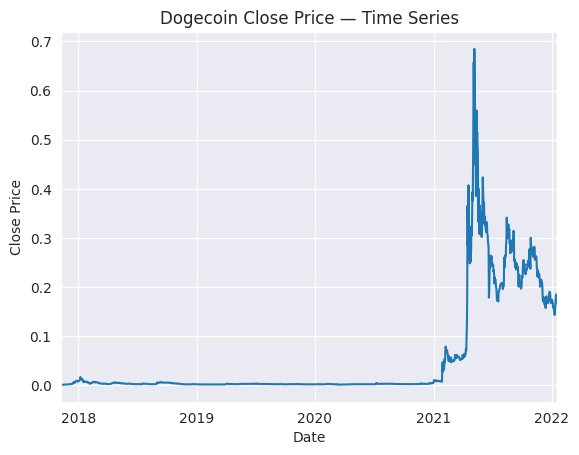

In [88]:
# Time-series line plot
fig, ax = plt.subplots()
df['Close'].plot(ax=ax, title='Dogecoin Close Price — Time Series')
ax.set_ylabel('Close Price')
plt.show()

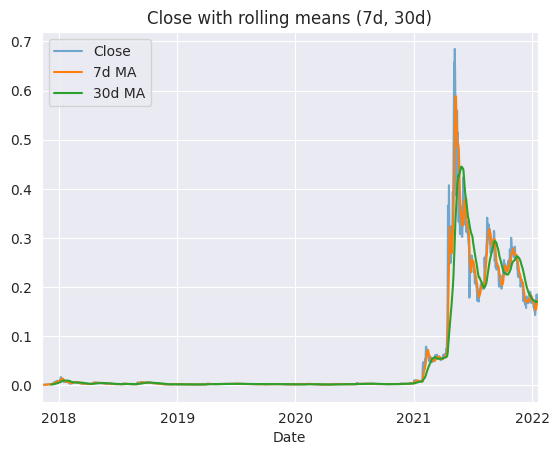

In [89]:
# Rolling stats: short and long window
fig, ax = plt.subplots()
df["Close"].plot(ax=ax, alpha=0.6, label='Close')
df["Close"].rolling(7).mean().plot(ax=ax, label='7d MA')
df["Close"].rolling(30).mean().plot(ax=ax, label='30d MA')
ax.legend()
ax.set_title('Close with rolling means (7d, 30d)')
plt.show()

### STL

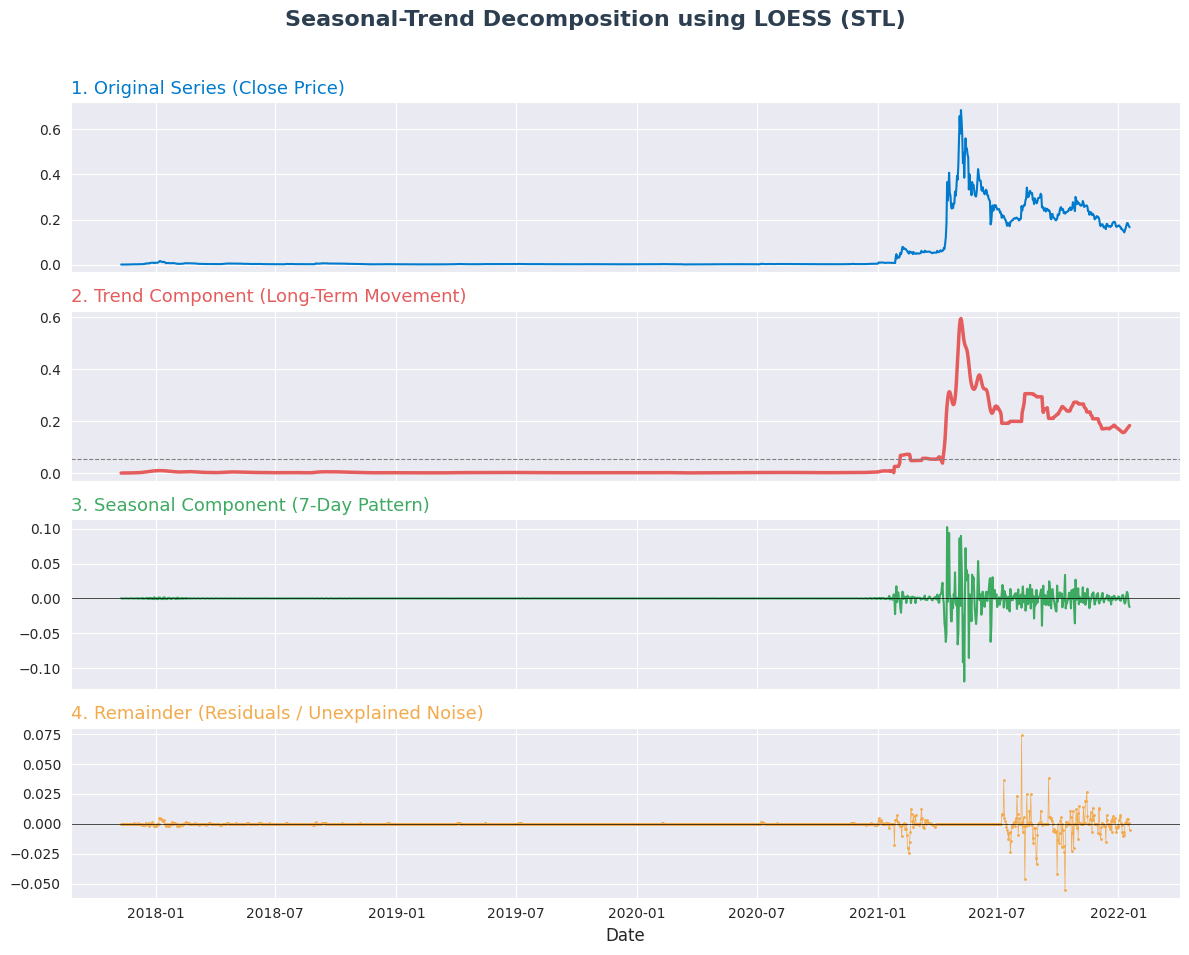

In [90]:
from statsmodels.tsa.seasonal import STL
# Season value can be tuned
# We will be using robust to handle potential outliers in the data
stl = STL(df['Close'], seasonal=7, robust=True)
res = stl.fit()

# Define distinct colors for visual separation
COLOR_ORIGINAL = '#007ACC'  # Deep Blue
COLOR_TREND = '#E55C5C'     # Muted Red
COLOR_SEASONAL = '#3DAA62'  # Medium Green
COLOR_RESIDUAL = '#F2AA4C'  # Warm Orange

# Create the figure with 4 stacked subplots, sharing the x-axis (time)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Main Title for the Entire Figure
fig.suptitle('Seasonal-Trend Decomposition using LOESS (STL)', fontsize=16, fontweight='bold', color='#2c3e50')

# 1. Original Series
axes[0].plot(df.index, df['Close'], color=COLOR_ORIGINAL, linewidth=1.5)
axes[0].set_title('1. Original Series (Close Price)', fontsize=13, loc='left', color=COLOR_ORIGINAL)
axes[0].tick_params(axis='y', labelsize=10)

# 2. Trend Component
axes[1].plot(df.index, res.trend, color=COLOR_TREND, linewidth=2.5)
axes[1].set_title('2. Trend Component (Long-Term Movement)', fontsize=13, loc='left', color=COLOR_TREND)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].axhline(y=res.trend.mean(), color='grey', linestyle='--', linewidth=0.8) # Optional mean line

# 3. Seasonal Component
axes[2].plot(df.index, res.seasonal, color=COLOR_SEASONAL, linewidth=1.5)
axes[2].set_title('3. Seasonal Component (7-Day Pattern)', fontsize=13, loc='left', color=COLOR_SEASONAL)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].axhline(0, color='black', linewidth=0.5)

# 4. Residual Component (The "Loss" or Remainder)
axes[3].plot(df.index, res.resid, color=COLOR_RESIDUAL, linewidth=0.5, marker='.', markersize=2)
axes[3].set_title('4. Remainder (Residuals / Unexplained Noise)', fontsize=13, loc='left', color=COLOR_RESIDUAL)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].axhline(0, color='black', linewidth=0.5)

# Final Layout Adjustments
plt.xlabel('Date', fontsize=12)
# Improve the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Autocorrelation

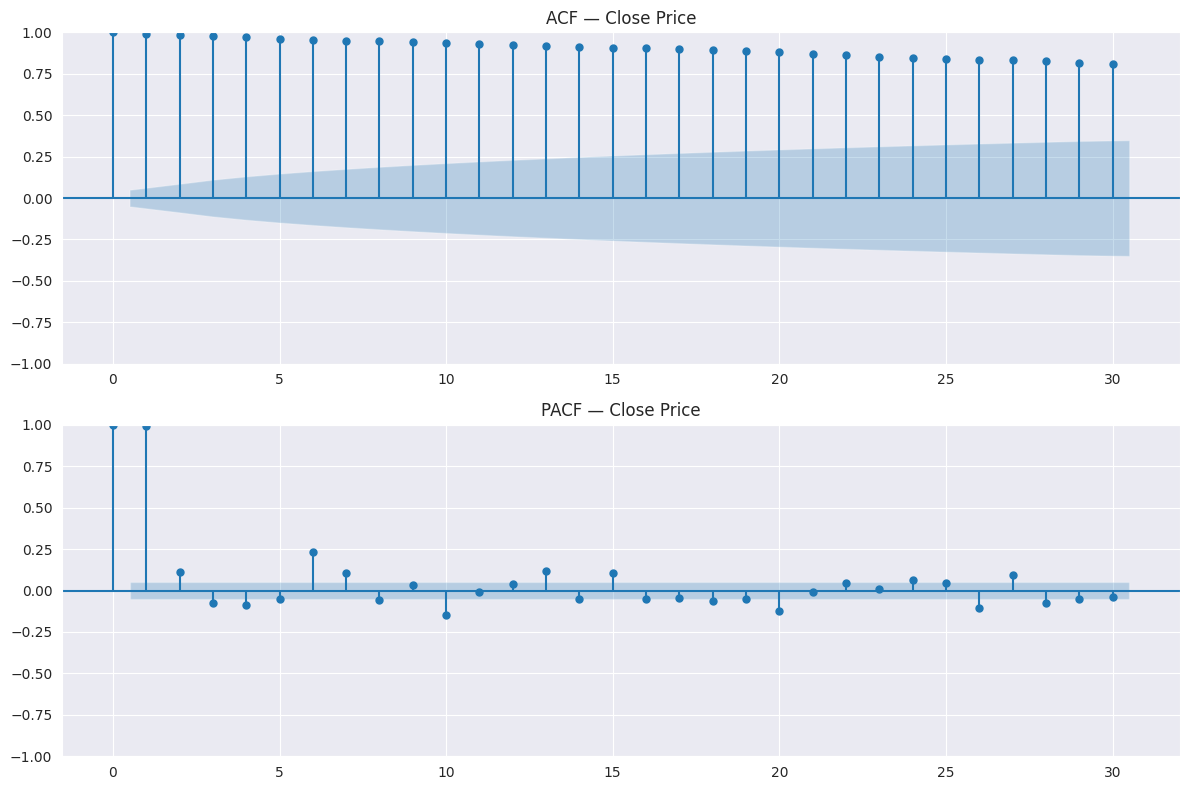

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 30
# ACF and PACF plots (lags in days)
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['Close'].dropna(), ax=ax[0], lags=nlags)
ax[0].set_title('ACF — Close Price')

plot_pacf(df['Close'].dropna(), ax=ax[1], lags=nlags)
ax[1].set_title('PACF — Close Price')
plt.tight_layout()
plt.show()


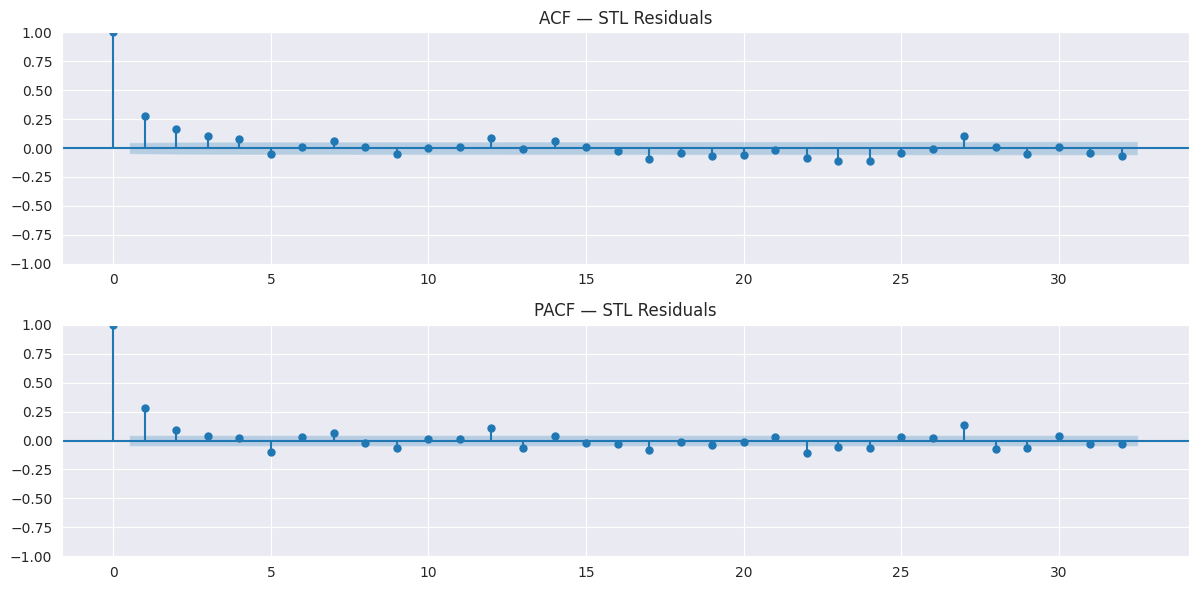

In [92]:
# Also check on residuals from STL to see if the decomposition removed autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,6))
plot_acf(res.resid.dropna(), ax=ax[0])
ax[0].set_title('ACF — STL Residuals')
plot_pacf(res.resid.dropna(), ax=ax[1])
ax[1].set_title('PACF — STL Residuals')
plt.tight_layout()
plt.show()

---

### Week 3

In [93]:
# DATA PRETREATMENT
df = df.asfreq('D')

# Check for missing values after resampling
print("Missing values per column after resampling:")
print(df.isna().sum())


Missing values per column after resampling:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [94]:
# Detect outliers using STL decomposition
from statsmodels.tsa.seasonal import STL

# STL decomposition to find residuals
stl_week3 = STL(df['Close'], period=7, robust=True)
res_week3 = stl_week3.fit()
residuals = res_week3.resid

# Identify outliers
outliers = residuals[(residuals > residuals.mean() + 3*residuals.std()) |
                     (residuals < residuals.mean() - 3*residuals.std())]

print(f"\nNumber of outliers detected: {len(outliers)}")
print(outliers.head())



Number of outliers detected: 30
Date
2021-01-26   -0.017833
2021-02-15   -0.020405
2021-02-16   -0.020214
2021-02-17   -0.024841
2021-02-18   -0.014819
Name: resid, dtype: float64


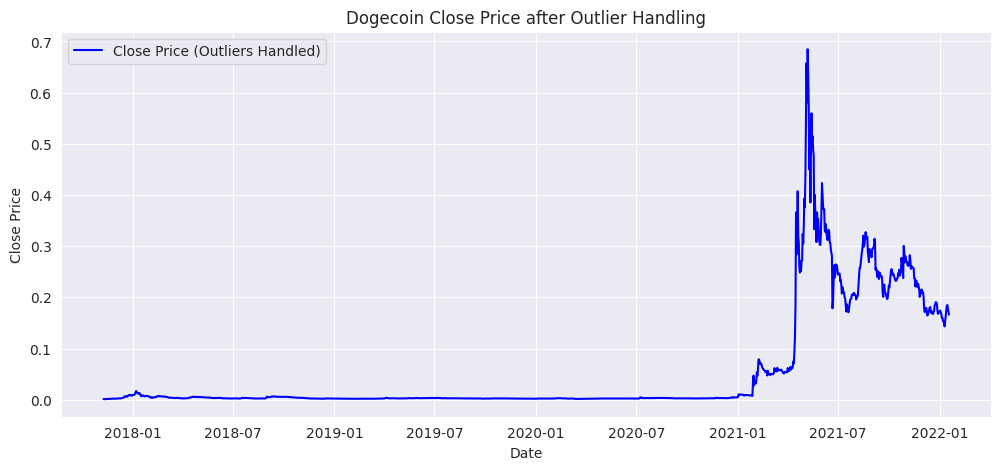

In [95]:
# Replace outliers in 'Close' with NaN, then interpolate
df['Close'] = df['Close'].mask((residuals > residuals.mean() + 3*residuals.std()) |
                                (residuals < residuals.mean() - 3*residuals.std()))
df['Close'] = df['Close'].interpolate(method='linear')

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


### Checkin if the data is stationary or non-stationary

In [96]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'])
print('p-value:', result[1])
#If p > 0.05 → series is non-stationary

p-value: 0.2843025169145415


### Applying log transformation to transform the data from additive to multiplicative

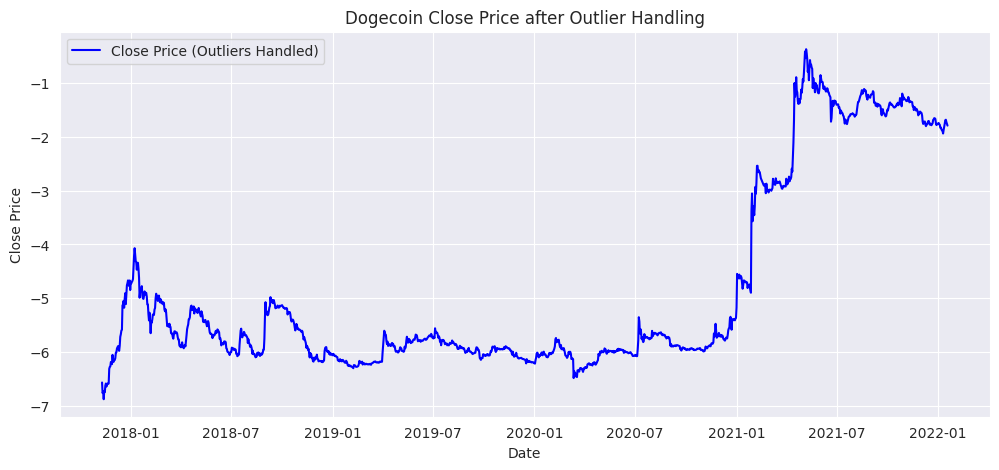

In [97]:
import numpy as np
df["Close_log"] = np.log(df["Close"])

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close_log'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [98]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close_log'])
print('p-value:', result[1])
#If p > 0.05 → series is non-stationary

p-value: 0.8700699314336868


### Creating a new column named difference to make the data stationary

/tmp/ipython-input-3994431623.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close_diff_log"].fillna(0, inplace=True)


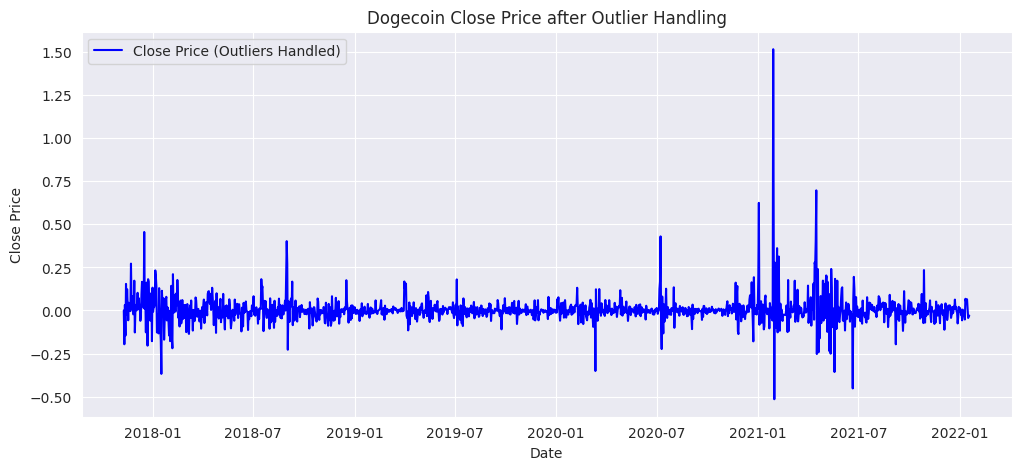

In [99]:
df["Close_diff_log"] = df["Close_log"].diff().dropna()
df["Close_diff_log"].fillna(0, inplace=True)

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close_diff_log'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [100]:
# Split data: 70% train, 30% test
train_size = int(len(df) * 0.7)
train, test = df['Close_diff_log'][:train_size], df['Close_diff_log'][train_size:]

### Finding out which lag would result in a good model

In [101]:
# To find out optimal lag based on AIC
from statsmodels.tsa.ar_model import AutoReg

results = {}
for lag in range(1, 30):  # try lags 1 to 14
    model = AutoReg(train, lags=lag).fit()
    results[lag] = model.aic

best_lag = min(results, key=results.get)
print("Best lag based on AIC:", best_lag)

Best lag based on AIC: 5



Baseline AR Model RMSE: 0.118988


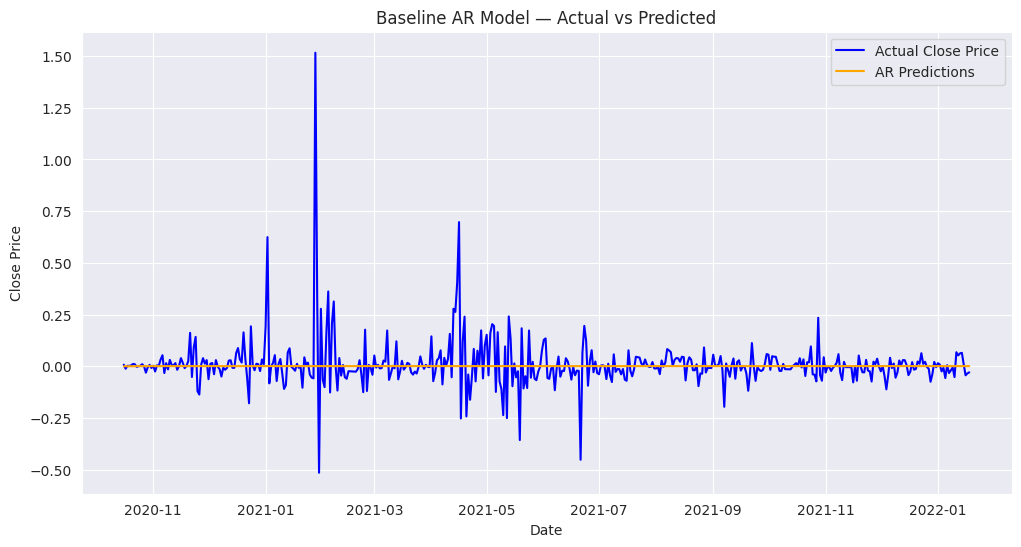

In [102]:
# Baseline Autoregressive Model
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sklearn.metrics import mean_squared_error

# Fit AR model with 7 lag days
ar_model = AutoReg(train, lags=7).fit()

# Predictions on test set
preds = ar_model.predict(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False)

# Evaluate baseline performance
mse = mean_squared_error(test, preds)
rmse = np.sqrt(mse)
print(f"\nBaseline AR Model RMSE: {rmse:.6f}")

# Convert predictions back to price
# Last known log price before test period
last_train_log_price = df["Close"].loc[train.index[-1]]

price_preds = []
current_log_price = last_train_log_price
for r in preds:
    current_log_price += r
    price_preds.append(np.exp(current_log_price))

price_preds = pd.Series(price_preds, index=test.index)

# Plot AR predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual Close Price', color='blue')
plt.plot(test.index, preds, label='AR Predictions', color='orange')

plt.title('Baseline AR Model — Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.show()

# plt.figure(figsize=(12,6))
# plt.plot(df["Close"].loc[train.index], label='Train (Actual)', color='green')
# plt.plot(df["Close"].loc[test.index], label='Test (Actual)', color='blue')
# plt.plot(price_preds, label='AR Predictions', color='orange')
# plt.title('Baseline AR Model — Dogecoin Close Price')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.show()

- The AR model produced a nearly flat line prediction (close to zero) on the differenced log transformed series. This indicates that the model primarily captured the mean of the return series, which is usually zero, suggesting that the model coefficients for past lags were insufficient or negligible compared to the series' overall volatility.

- The model failed completely to capture the large, unpredictable spikes (high variance) present in the differenced series. This failure arises because the basic AR model assumes constant variance (homoskedasticity) in its residuals, an assumption that is severely violated by crypto returns, which shows heteroskedasticity (time varying variance).

- The poor baseline performance confirms that a simple linear model like AR is inadequate for this task. It establishes the necessity of moving to more complex models like ARIMA or, more importantly Recurrent Neural Networks (RNN/LSTM), which are better equipped to capture the non linear, high frequency dependencies in the time series residuals.

---

### Week 4

### RNN

In [103]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))  # or (0,1)
scaled_data = scaler.fit_transform(df["Close_log"].values.reshape(-1,1))

In [104]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
train_size = int(0.8 * len(scaled_data))

X_train, y_train = create_sequences(scaled_data[:train_size], seq_len)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_len)

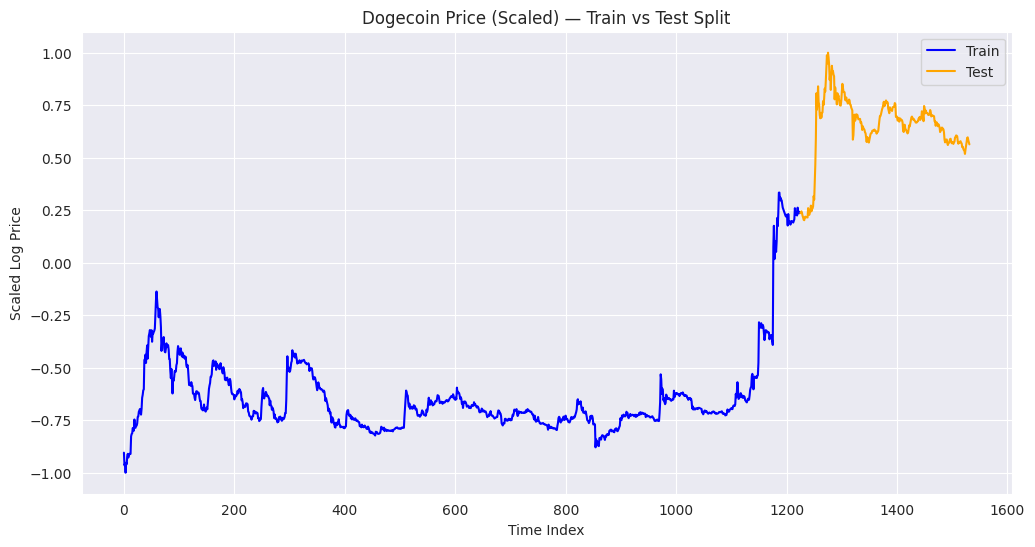

In [105]:
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(range(train_size), scaled_data[:train_size], label='Train', color='blue')

# Plot test data
plt.plot(range(train_size, len(scaled_data)), scaled_data[train_size:], label='Test', color='orange')

plt.title("Dogecoin Price (Scaled) — Train vs Test Split")
plt.xlabel("Time Index")
plt.ylabel("Scaled Log Price")
plt.legend()
plt.show()

In [106]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # take last timestep
        return out

# Convert data to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Initialize model, loss, optimizer
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = []

# Training loop
epochs = 600
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 50/600, Loss: 0.024767
Epoch 100/600, Loss: 0.001957
Epoch 150/600, Loss: 0.001647
Epoch 200/600, Loss: 0.001535
Epoch 250/600, Loss: 0.001436
Epoch 300/600, Loss: 0.001349
Epoch 350/600, Loss: 0.001281
Epoch 400/600, Loss: 0.001232
Epoch 450/600, Loss: 0.001197
Epoch 500/600, Loss: 0.001171
Epoch 550/600, Loss: 0.001149
Epoch 600/600, Loss: 0.001129


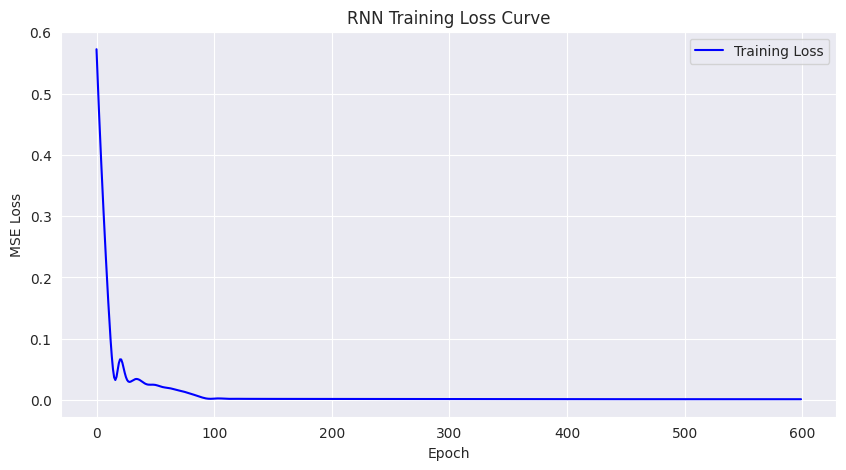

In [107]:
plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.title("RNN Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [108]:
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_t).numpy()

# Inverse transform predictions
pred_log = scaler.inverse_transform(pred_scaled)
actual_log = scaler.inverse_transform(y_test.reshape(-1, 1))

pred_price = np.exp(pred_log)
actual_price = np.exp(actual_log)

RNN Test RMSE: 0.069360


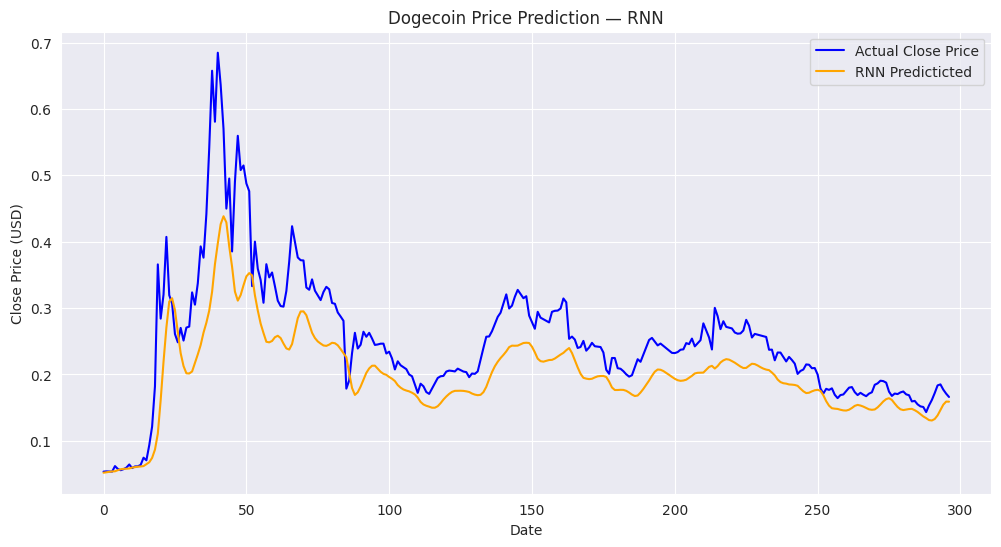

In [109]:
rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"RNN Test RMSE: {rmse:.6f}")

plt.figure(figsize=(12,6))
plt.plot(actual_price, label='Actual Close Price', color='blue')
plt.plot(pred_price, label='RNN Predicticted', color='orange')

plt.title('Dogecoin Price Prediction — RNN')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()

plt.show()

### LSTM

In [110]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 600
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


Epoch 50/600, Loss: 0.009859
Epoch 100/600, Loss: 0.001737
Epoch 150/600, Loss: 0.001594
Epoch 200/600, Loss: 0.001516
Epoch 250/600, Loss: 0.001430
Epoch 300/600, Loss: 0.001337
Epoch 350/600, Loss: 0.001239
Epoch 400/600, Loss: 0.001138
Epoch 450/600, Loss: 0.001044
Epoch 500/600, Loss: 0.000983
Epoch 550/600, Loss: 0.000945
Epoch 600/600, Loss: 0.000913


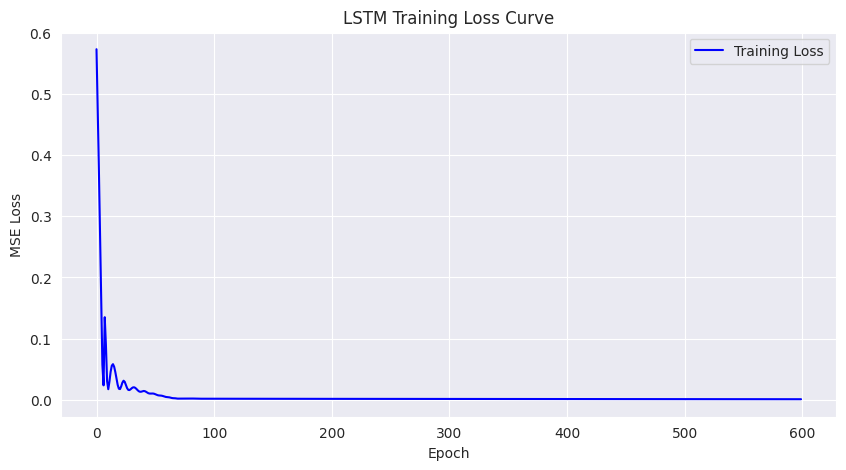

In [111]:
plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.title("LSTM Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

LSTM Test RMSE: 0.086540


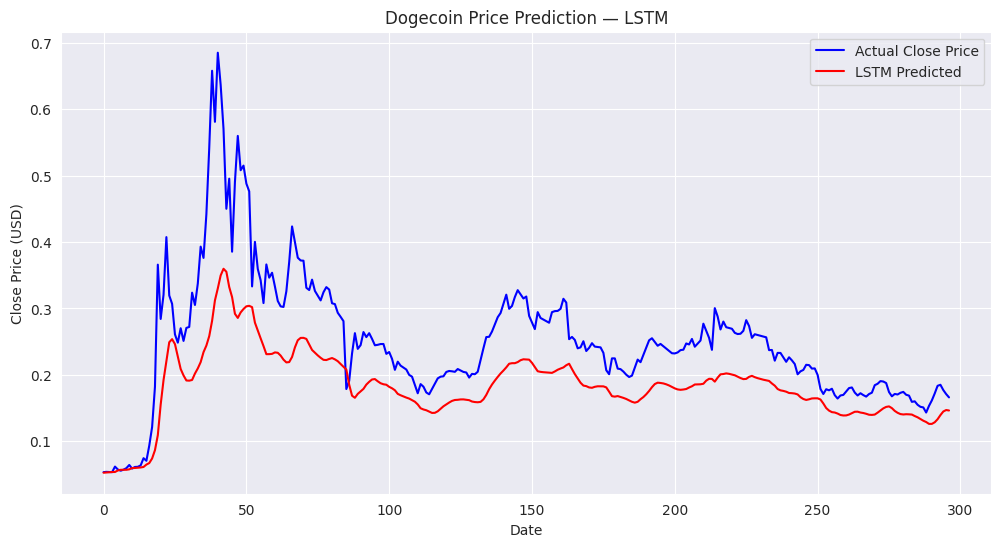

In [112]:
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_t).numpy()

# Inverse transform
pred_log = scaler.inverse_transform(pred_scaled)
actual_log = scaler.inverse_transform(y_test.reshape(-1,1))

# Convert back from log
pred_price = np.exp(pred_log)
actual_price = np.exp(actual_log)

rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"LSTM Test RMSE: {rmse:.6f}")

plt.figure(figsize=(12,6))
plt.plot(actual_price, label='Actual Close Price', color='blue')
plt.plot(pred_price, label='LSTM Predicted', color='red')
plt.title("Dogecoin Price Prediction — LSTM")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

# Week 5

In [113]:
# ===TRANSFORMER Forecaseter===

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, optimizers
import numpy as np

# Safety check
try:
    X_train, X_test, y_train, y_test
except NameError:
    raise NameError("Dataset variables missing.")

seq_length = X_train.shape[1]
n_features = X_train.shape[2]


# Positional Encoding (same as your best version)
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        dims = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)

        angle_rates = 1.0 / tf.pow(10000.0, (2 * (dims // 2)) / self.d_model)
        angle_rads = pos * angle_rates

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pe = tf.concat([sines, cosines], axis=-1)
        pe = pe[tf.newaxis, ...]

        return x + pe


# Transformer encoder (correct FFN output dimension = d_model)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):

    # Multi-head attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size
    )(inputs, inputs)

    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward network
    ff = layers.Dense(ff_dim, activation="relu")(out1)
    ff = layers.Dense(int(out1.shape[-1]))(ff)  #output = d_model=64
    ff = layers.Dropout(dropout)(ff)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ff)


# Build transformer model
d_model = 64

inputs = layers.Input(shape=(seq_length, n_features))
x = layers.Dense(d_model)(inputs)
x = PositionalEncoding(d_model)(x)

x = transformer_encoder(
    x,
    head_size=32,
    num_heads=4,
    ff_dim=128,
    dropout=0.1
)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)

transformer_model = models.Model(inputs, outputs)
transformer_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

transformer_model.summary()

# Training
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_tr = transformer_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

preds_trans_scaled = transformer_model.predict(X_test).squeeze()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10, 64)    │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 64)    │          0 │ dense_15[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     33,216 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 10, 64)    │          0 │ positional_encod… │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10, 64)    │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 10, 64)    │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         33 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,289 (204.25 KB)

 Trainable params: 52,289 (204.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
35/35 - 11s - 311ms/step - loss: 0.1139 - mean_absolute_error: 0.2161 - val_loss: 0.2896 - val_mean_absolute_error: 0.4179
Epoch 2/10
35/35 - 3s - 75ms/step - loss: 0.0121 - mean_absolute_error: 0.0836 - val_loss: 0.1521 - val_mean_absolute_error: 0.3269
Epoch 3/10
35/35 - 0s - 6ms/step - loss: 0.0059 - mean_absolute_error: 0.0593 - val_loss: 0.0363 - val_mean_absolute_error: 0.1441
Epoch 4/10
35/35 - 0s - 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0481 - val_loss: 0.0343 - val_mean_absolute_error: 0.1564
Epoch 5/10
35/35 - 0s - 5ms/step - loss: 0.0043 - mean_absolute_error: 0.0496 - val_loss: 0.0192 - val_mean_absolute_error: 0.0980
Epoch 6/10
35/35 - 0s - 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0442 - val_loss: 0.0218 - val_mean_absolute_error: 0.1086
Epoch 7/10
35/35 - 0s - 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 0.0177 - val_mean_absolute_error: 0.0948
Epoch 8/10
35/35 - 0s - 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 -

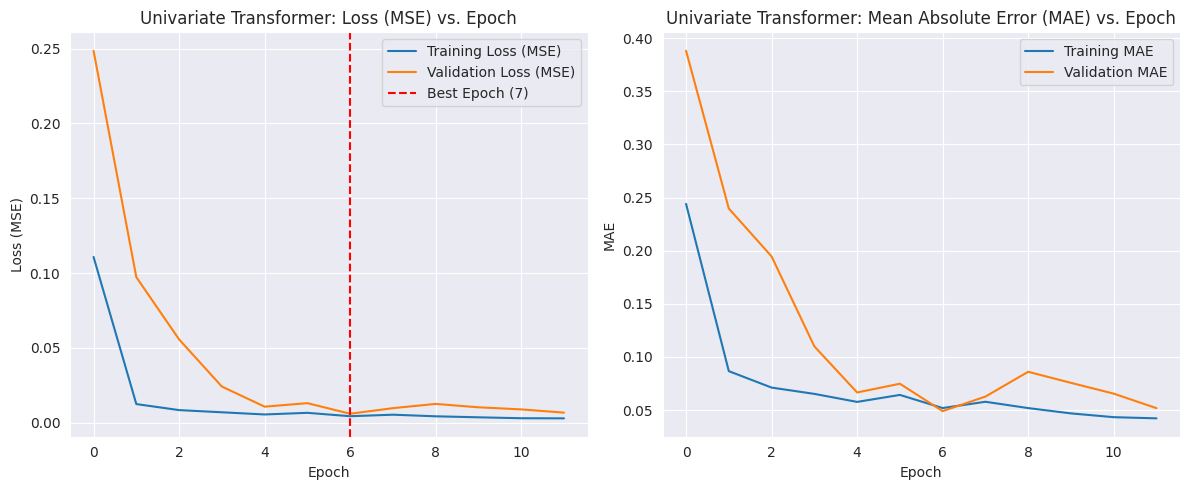

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' is the object returned by transformer_model.fit()
# history = transformer_model.fit(...)

def plot_loss_curves(history, title_prefix="Transformer Model"):
    """
    Plots the training and validation loss (MSE) and MAE curves.

    Args:
        history (tf.keras.callbacks.History): The history object returned by model.fit().
        title_prefix (str): Prefix for the chart titles (e.g., "Univariate" or "Multivariate").
    """
    # 1. Plot Loss (Mean Squared Error)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    # Check if 'loss' is in history keys (standard for Keras)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss (MSE)')
        plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')

        # Highlight the point where Early Stopping likely occurred
        if history.history['val_loss']:
            best_val_loss = min(history.history['val_loss'])
            best_epoch = np.argmin(history.history['val_loss'])
            plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')

        plt.title(f'{title_prefix}: Loss (MSE) vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
    else:
        print("Loss history data not found.")

    # 2. Plot Mean Absolute Error (MAE)
    plt.subplot(1, 2, 2)

    # Check if 'mean_absolute_error' is in history keys
    if 'mean_absolute_error' in history.history and 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'], label='Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')

        plt.title(f'{title_prefix}: Mean Absolute Error (MAE) vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    else:
        print("MAE history data not found.")

    plt.tight_layout()
    plt.show()
plot_loss_curves(history, title_prefix="Univariate Transformer")

X_train shape: (1215, 10, 1)
y_train shape: (1215, 1)
X_test shape: (297, 10, 1)
y_test shape: (297, 1)
Transformer preds (raw) shape: (297,)
Transformer forward pass OK — output shape: (4, 1)
Inverse transform to price scale succeeded.

=== Metrics summary ===
LSTM_MSE: 0.007489
LSTM_MAE: 0.067808
TRANS_MSE: 0.024439
TRANS_MAE: 0.136888
NAIVE_MSE: 0.000851
NAIVE_MAE: 0.015433


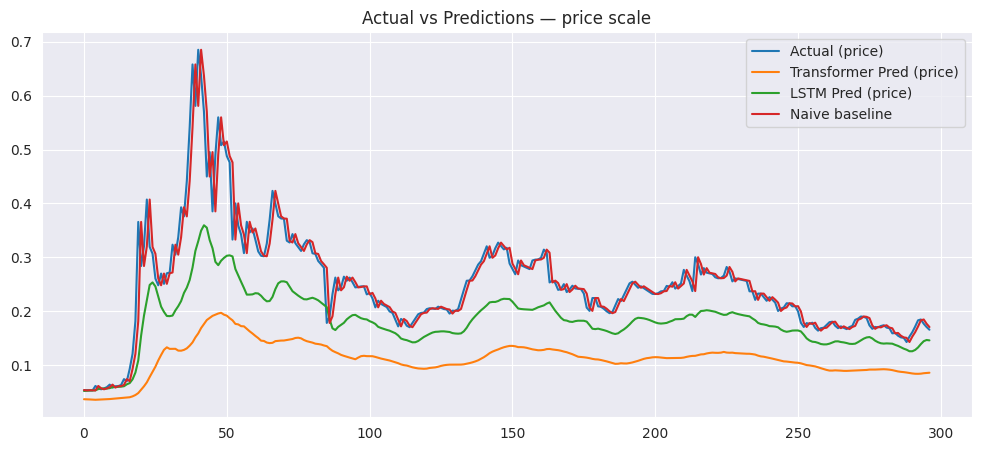

In [115]:
# --- CELL B: Correctness checks & baseline comparison ---
# Shape checks, forward-pass sanity, naive baseline, error metrics, and plots.
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1) Basic shape checks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Transformer preds (raw) shape:", preds_trans_scaled.shape)

# 2) Forward-pass sanity test (random synthetic batch)
try:
    random_batch = np.random.randn(4, X_train.shape[1], X_train.shape[2]).astype(np.float32)
    out = transformer_model(random_batch)
    print("Transformer forward pass OK — output shape:", out.shape)
except Exception as e:
    print("Forward pass failed:", e)

# 3) Attempt inverse transform to price scale if 'scaler' exists and you used log-transform
has_scaler = 'scaler' in globals()
if has_scaler:
    try:
        preds_trans_log = scaler.inverse_transform(preds_trans_scaled.reshape(-1,1))
        preds_trans_price = np.exp(preds_trans_log)
        y_test_arr = np.array(y_test).reshape(-1,1)
        y_test_log = scaler.inverse_transform(y_test_arr)
        y_test_price = np.exp(y_test_log)
        print("Inverse transform to price scale succeeded.")
    except Exception as e:
        print("Inverse transform failed:", e)
        has_scaler = False

# 4) Naive baseline: predict last observed value of each input sequence
# Assumes the target corresponds to feature index 0
naive_scaled = X_test[:, -1, 0]
if has_scaler:
    naive_price = np.exp(scaler.inverse_transform(naive_scaled.reshape(-1,1)))
else:
    naive_price = naive_scaled

# 5) Compute metrics
metrics = {}
# If your notebook already computed LSTM predictions and stored them (e.g. 'pred_price'), include it
if 'pred_price' in globals() and has_scaler:
    try:
        lstm_pred_price = np.squeeze(pred_price)
        metrics['LSTM_MSE'] = mean_squared_error(y_test_price, lstm_pred_price)
        metrics['LSTM_MAE'] = mean_absolute_error(y_test_price, lstm_pred_price)
    except Exception as e:
        print("Could not compute LSTM metrics on price scale:", e)

# Transformer metrics prefer price scale if available, else scaled-space metrics
if has_scaler:
    trans_pred_price = np.squeeze(preds_trans_price)
    metrics['TRANS_MSE'] = mean_squared_error(y_test_price, trans_pred_price)
    metrics['TRANS_MAE'] = mean_absolute_error(y_test_price, trans_pred_price)
    # Baseline
    metrics['NAIVE_MSE'] = mean_squared_error(y_test_price, np.squeeze(naive_price))
    metrics['NAIVE_MAE'] = mean_absolute_error(y_test_price, np.squeeze(naive_price))
else:
    y_true_scaled = np.array(y_test).reshape(-1,)
    metrics['TRANS_MSE_scaled'] = mean_squared_error(y_true_scaled, preds_trans_scaled)
    metrics['TRANS_MAE_scaled'] = mean_absolute_error(y_true_scaled, preds_trans_scaled)
    metrics['NAIVE_MSE_scaled'] = mean_squared_error(y_true_scaled, naive_scaled)
    metrics['NAIVE_MAE_scaled'] = mean_absolute_error(y_true_scaled, naive_scaled)

# Print metrics
print("\n=== Metrics summary ===")
for k, v in metrics.items():
    print(f"{k}: {v:.6f}")

# 6) Quick visualization: actual vs transformer vs LSTM vs naive
plt.figure(figsize=(12,5))
if has_scaler:
    plt.plot(y_test_price, label='Actual (price)')
    plt.plot(preds_trans_price, label='Transformer Pred (price)')
    if 'pred_price' in globals():
        plt.plot(np.squeeze(pred_price), label='LSTM Pred (price)')
    plt.plot(np.squeeze(naive_price), label='Naive baseline')
    plt.legend()
    plt.title('Actual vs Predictions — price scale')
else:
    plt.plot(np.array(y_test).reshape(-1,), label='Actual (scaled)')
    plt.plot(preds_trans_scaled, label='Transformer Pred (scaled)')
    if 'pred_price' in globals():
        plt.plot(np.squeeze(pred_price), label='LSTM Pred (maybe price-scaled)')
    plt.plot(naive_scaled, label='Naive baseline (scaled)')
    plt.legend()
    plt.title('Actual vs Predictions — scaled scale')
plt.show()


Multivariate

In [116]:
import numpy as np
import pandas as pd

# --- FEATURES ---
df["Close_log"] = np.log(df["Close"])
df["Volume_log"] = np.log(df["Volume"] + 1)   # avoid log(0)

# Input features (X)
features_X = df[["Close_log", "Volume_log"]].values
# Target feature (Y) - only Close_log
features_Y = df[["Close_log"]].values

from sklearn.preprocessing import MinMaxScaler

# Scaler for INPUT features (2 columns)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaled_data_X = scaler_X.fit_transform(features_X)

# Scaler for TARGET feature (1 column)
scaler_Y = MinMaxScaler(feature_range=(-1, 1))
scaled_data_Y = scaler_Y.fit_transform(features_Y)

# Select multivariate features
features = df[["Close_log", "Volume_log"]].values

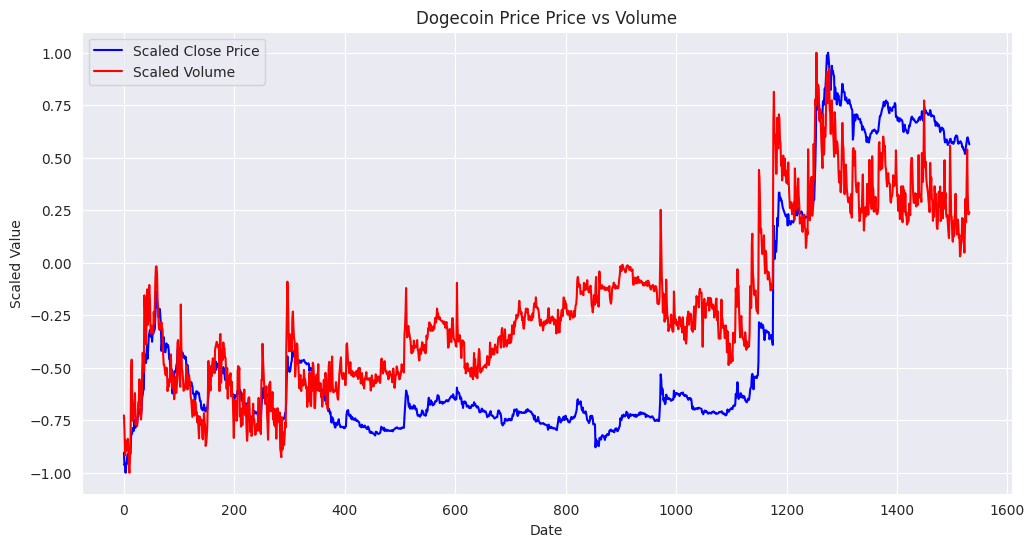

In [117]:
plt.figure(figsize=(12,6))
plt.plot(scaled_data_X[:, 0], label='Scaled Close Price', color='blue')
plt.plot(scaled_data_X[:, 1], label='Scaled Volume', color='red')
plt.title("Dogecoin Price Price vs Volume")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.show()

In [118]:
def create_sequences(data_X, data_Y, seq_len):
    X, y = [], []
    # Loop over the INPUT data (data_X)
    for i in range(len(data_X) - seq_len):
        X.append(data_X[i:i+seq_len])
        # Target y comes from the SCALED TARGET data (data_Y)
        y.append(data_Y[i+seq_len, 0])
    return np.array(X), np.array(y)

seq_len = 10
train_size = int(0.8 * len(scaled_data_X))

# Pass X and Y scaled data separately
X_train, y_train = create_sequences(
    scaled_data_X[:train_size],
    scaled_data_Y[:train_size],
    seq_len
)
X_test, y_test = create_sequences(
    scaled_data_X[train_size:],
    scaled_data_Y[train_size:],
    seq_len
)
# The rest of your reshaping logic for y_train/y_test remains the same

In [119]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1215, 10, 2)
(1215,)
(297, 10, 2)
(297,)


In [120]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses

seq_length = X_train.shape[1]
n_features = X_train.shape[2]

# Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        dims = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)
        angle_rates = 1.0 / tf.pow(10000.0, (2 * (dims // 2)) / self.d_model)
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pe = tf.concat([sines, cosines], axis=-1)
        pe = pe[tf.newaxis, ...]
        return x + pe


# Encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn)

    ff = layers.Dense(ff_dim, activation="relu")(out1)
    ff = layers.Dense(out1.shape[-1])(ff)
    ff = layers.Dropout(dropout)(ff)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ff)


# Build model
d_model = 64
inputs = layers.Input(shape=(seq_length, n_features))
x = layers.Dense(d_model)(inputs)
x = PositionalEncoding(d_model)(x)

x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=128, dropout=0.1)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)  # Close_log prediction

transformer_model = models.Model(inputs, outputs)
transformer_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10, 64)    │        192 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 64)    │          0 │ dense_20[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     33,216 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 10, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 10, 64)    │          0 │ positional_encod… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10, 64)    │      8,256 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 10, 64)    │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │         33 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,353 (204.50 KB)

 Trainable params: 52,353 (204.50 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = transformer_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/20
35/35 - 12s - 345ms/step - loss: 0.0704 - mean_absolute_error: 0.1878 - val_loss: 0.2932 - val_mean_absolute_error: 0.4567
Epoch 2/20
35/35 - 0s - 5ms/step - loss: 0.0114 - mean_absolute_error: 0.0811 - val_loss: 0.1884 - val_mean_absolute_error: 0.3669
Epoch 3/20
35/35 - 0s - 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0560 - val_mean_absolute_error: 0.1900
Epoch 4/20
35/35 - 0s - 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0205 - val_mean_absolute_error: 0.1017
Epoch 5/20
35/35 - 0s - 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0440 - val_loss: 0.0199 - val_mean_absolute_error: 0.1066
Epoch 6/20
35/35 - 0s - 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0411 - val_loss: 0.0091 - val_mean_absolute_error: 0.0553
Epoch 7/20
35/35 - 0s - 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0401 - val_loss: 0.0060 - val_mean_absolute_error: 0.0453
Epoch 8/20
35/35 - 0s - 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0435 - 

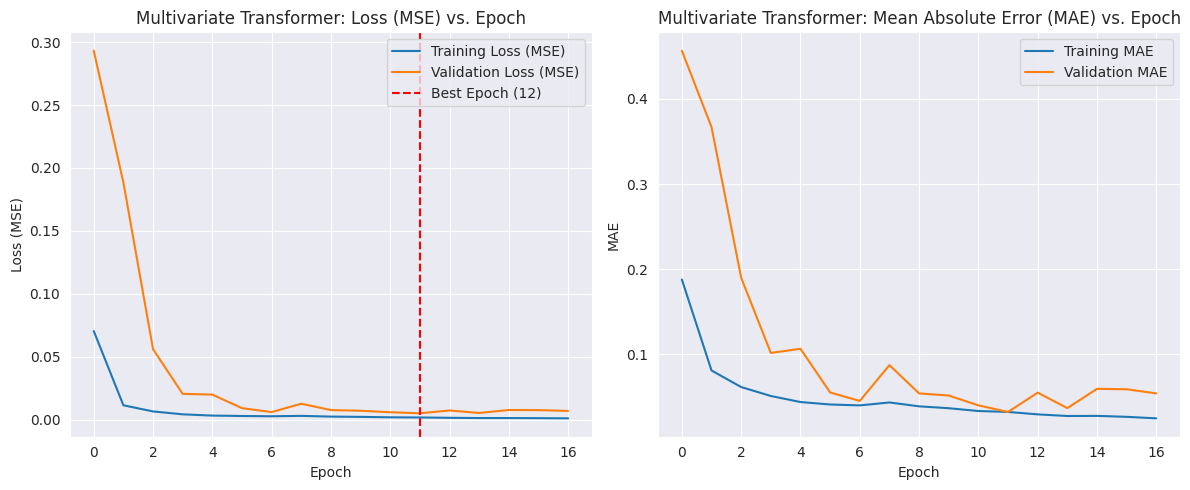

In [122]:
# --- Example Usage ---
# Use the 'history' object from the model fitting step
plot_loss_curves(history, title_prefix="Multivariate Transformer")

In [123]:
pred_scaled = transformer_model.predict(X_test).squeeze()

# Inverse transform using the TARGET SCALER (scaler_Y)
# Note: pred_scaled is already 1D, so we just reshape it to 2D (Nx1) for the scaler.
pred_log = scaler_Y.inverse_transform(pred_scaled.reshape(-1, 1)).squeeze()

# Inverse transform the actual test values using the TARGET SCALER
y_test_log = scaler_Y.inverse_transform(y_test.reshape(-1, 1)).squeeze()

# Back to real prices
pred_price = np.exp(pred_log)
actual_price = np.exp(y_test_log)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


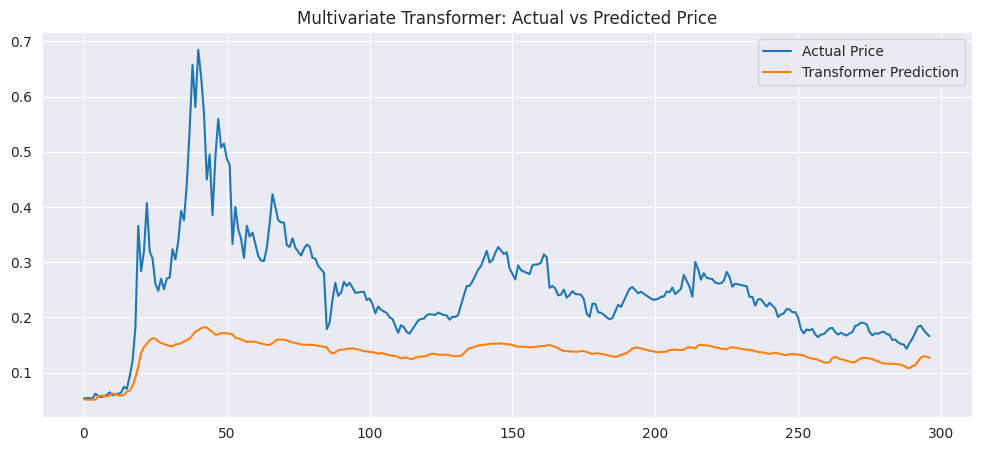

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(actual_price, label="Actual Price")
plt.plot(pred_price, label="Transformer Prediction")
plt.legend()
plt.title("Multivariate Transformer: Actual vs Predicted Price")
plt.show()